In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

# Load data

In [4]:
%%time

calendar = pd.read_csv('../input_data/calendar.csv').pipe(reduce_mem_usage, verbose=True)
calendar['date'] = pd.to_datetime(calendar['date'])

Mem. usage decreased to  0.12 Mb (41.9% reduction)
CPU times: user 17.6 ms, sys: 2.41 ms, total: 20 ms
Wall time: 19.3 ms


In [5]:
%%time

sales = pd.read_csv('../input_data/sales_train_evaluation.csv').pipe(reduce_mem_usage, verbose=True)

Mem. usage decreased to 95.61 Mb (78.9% reduction)
CPU times: user 1min 38s, sys: 29.8 s, total: 2min 8s
Wall time: 2min 8s


In [6]:
%%time

sell_prices = pd.read_csv('../input_data/sell_prices.csv').pipe(reduce_mem_usage, verbose=True)

Mem. usage decreased to 143.53 Mb (31.2% reduction)
CPU times: user 1.94 s, sys: 173 ms, total: 2.12 s
Wall time: 2.12 s


# Create a master data table
- Training data: 2015-03-25 to 2016-04-24 (d1 - d1913)
- Validation data: 2016-04-25 to 2016-05-22 (d1914 - d1941)
- Test/Submission data: 2016-05-23 to 2016-06-19 (d1942 - d1969)

In [7]:
## add columns for submission

for i in range(1942, 1970):
    sales['d_%d' % i] = 0

In [8]:
%%time

sales_by_date = pd.melt(
    sales,
    id_vars=['id','item_id','dept_id','cat_id','store_id','state_id'],
    var_name='d',
    value_name='items_sold'
) \
.merge(calendar, on='d', how='left') \
.merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left') \
[['id', 'date', 'item_id','dept_id','cat_id','store_id','state_id','items_sold','weekday','wday','month','year',
  'event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI','sell_price']]

CPU times: user 59.8 s, sys: 16.4 s, total: 1min 16s
Wall time: 1min 17s


In [9]:
sales_by_date.to_pickle("../saved_data/sales_by_date_raw.pkl")

In [10]:
%%time

sales_by_date = pd.read_pickle("../saved_data/sales_by_date_raw.pkl")

CPU times: user 22.3 s, sys: 23.9 s, total: 46.2 s
Wall time: 50.3 s


In [11]:
## process the event name
sales_by_date['event_1_isna'] = (sales_by_date['event_name_1'].notna()).astype(int)
sales_by_date['event_2_isna'] = (sales_by_date['event_name_2'].notna()).astype(int)
sales_by_date['num_events'] = sales_by_date['event_1_isna'] + sales_by_date['event_2_isna']

sales_by_date['event_name_1'] = sales_by_date['event_name_1'].fillna('no_event')
sales_by_date['event_name_2'] = sales_by_date['event_name_2'].fillna('no_event')

In [12]:
## process the snap feature

sales_by_date.loc[sales_by_date['state_id'] == 'CA', 'snap'] = sales_by_date.loc[sales_by_date['state_id'] == 'CA']['snap_CA']
sales_by_date.loc[sales_by_date['state_id'] == 'TX', 'snap'] = sales_by_date.loc[sales_by_date['state_id'] == 'TX']['snap_TX']
sales_by_date.loc[sales_by_date['state_id'] == 'WI', 'snap'] = sales_by_date.loc[sales_by_date['state_id'] == 'WI']['snap_WI']
sales_by_date['snap'] = sales_by_date['snap'].astype(int)

In [13]:
## add the weekend feature

sales_by_date['is_weekend'] = (sales_by_date['wday'] <= 2).astype(int)

In [14]:
# select a smaller date range to save memory

sales_by_date = sales_by_date[sales_by_date['date'] >= '2014-02-24']

In [15]:
sales_by_date.head(2)

,id,date,item_id,dept_id,cat_id,store_id,state_id,items_sold,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,event_1_isna,event_2_isna,num_events,snap,is_weekend
34209780,HOBBIES_1_001_CA_1_evaluation,2014-02-24,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,Monday,3,2,2014,no_event,NaN,no_event,NaN,0,0,0,8.26,0,0,0,0,0
34209781,HOBBIES_1_002_CA_1_evaluation,2014-02-24,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,Monday,3,2,2014,no_event,NaN,no_event,NaN,0,0,0,3.97,0,0,0,0,0


In [16]:
# clean up the unused tables

import gc

del calendar, sell_prices, sales
gc.collect()

22

# Feature Engineering

### 1. Lag features

In [18]:
def create_features(df):
    '''
    create features using rolling and lag
    '''
    
    # these are hard-coded for final submission
    # groupby_cols, target_cols, agg_functions, rolling_windows, lags
    agg_list = [
        [['store_id', 'item_id'], 'items_sold', 'mean', [1], [7, 28,29,30,31,32,33,34,35,36,37,38,39,40,41,42]],
        [['store_id', 'item_id'], 'items_sold', 'mean', [7], [7, 365]],
        [['store_id', 'item_id'], 'items_sold', 'mean', [7, 14, 30, 60, 180], [28]],
        [['store_id', 'item_id'], 'items_sold', 'std',  [7, 14, 30, 60, 180], [28]],
        [['store_id', 'item_id'], 'sell_price', 'max', [365], [1]],
        [['store_id', 'item_id'], 'sell_price', 'mean', [7], [1]],
    ]
    
    for i, item in enumerate(agg_list):
        print(i)
        
        # unpack the parameters
        groupby_cols, target_col, agg_function, rolling_windows, lags = item
        groupby_col_str = "_".join(groupby_cols)
        
        for lag in lags:
            for rolling_window in rolling_windows:
                col_name = agg_function+'_'+target_col+'_per_'+groupby_col_str+'_r'+str(rolling_window)+'_lag_'+str(lag)
                df[col_name] = df.groupby(groupby_cols)[target_col].apply(lambda x: x.rolling(window=rolling_window).agg(agg_function).shift(lag))
              
    ## price related features
    df['sell_price_norm'] = df['sell_price'] / df['max_sell_price_per_store_id_item_id_r365_lag_1']
    df['sell_price_momentum'] = df['sell_price'] / df['mean_sell_price_per_store_id_item_id_r7_lag_1']

    return df

In [17]:
def update_features_one_day(df, date):
    '''
    update lag/rolling features for one day only
    
    used for submission creation, when the predictions for 28 days are performed recursively
    '''
    
    from datetime import timedelta
    
    agg_list = [
        [['store_id', 'item_id'], 'items_sold', 'mean', [1], [7]],
        [['store_id', 'item_id'], 'items_sold', 'mean', [7], [7]],
        [['store_id', 'item_id'], 'sell_price', 'max', [365], [1]],
        [['store_id', 'item_id'], 'sell_price', 'mean', [7], [1]],
    ]
    
    for i, item in enumerate(agg_list):
        
        # unpack the parameters
        groupby_cols, target_col, agg_function, rolling_windows, lags = item
        groupby_col_str = "_".join(groupby_cols)
        
        for lag in lags:
            for rolling_window in rolling_windows:
                col_name = agg_function+'_'+target_col+'_per_'+groupby_col_str+'_r'+str(rolling_window)+'_lag_'+str(lag)
                
                df_window = df[(df.date <= date-timedelta(days=lag)) & (df.date > date-timedelta(days=lag+rolling_window))]
                df_window_grouped = df_window.groupby("id").agg({target_col : agg_function}).reindex(df.loc[df.date==date, 'id'])
                df.loc[df.date == date, col_name] = df_window_grouped[target_col].values
                
    df.loc[df.date == date, 'sell_price_norm'] = df.loc[df.date == date, 'sell_price'] / df.loc[df.date == date, 'max_sell_price_per_store_id_item_id_r365_lag_1']
    df.loc[df.date == date, 'sell_price_momentum'] = df.loc[df.date == date, 'sell_price'] / df.loc[df.date == date, 'mean_sell_price_per_store_id_item_id_r7_lag_1']
    
    return df

In [19]:
sales_by_date = sales_by_date.set_index(['id', 'date'])

In [20]:
%%time

sales_by_date = create_features(sales_by_date)

0
1
2
3
4
5
CPU times: user 28min 59s, sys: 2min, total: 30min 59s
Wall time: 31min 10s


In [21]:
sales_by_date.head()

,,item_id,dept_id,cat_id,store_id,state_id,items_sold,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,event_1_isna,event_2_isna,num_events,snap,is_weekend,mean_items_sold_per_store_id_item_id_r1_lag_7,mean_items_sold_per_store_id_item_id_r1_lag_28,mean_items_sold_per_store_id_item_id_r1_lag_29,mean_items_sold_per_store_id_item_id_r1_lag_30,mean_items_sold_per_store_id_item_id_r1_lag_31,mean_items_sold_per_store_id_item_id_r1_lag_32,mean_items_sold_per_store_id_item_id_r1_lag_33,mean_items_sold_per_store_id_item_id_r1_lag_34,mean_items_sold_per_store_id_item_id_r1_lag_35,mean_items_sold_per_store_id_item_id_r1_lag_36,mean_items_sold_per_store_id_item_id_r1_lag_37,mean_items_sold_per_store_id_item_id_r1_lag_38,mean_items_sold_per_store_id_item_id_r1_lag_39,mean_items_sold_per_store_id_item_id_r1_lag_40,mean_items_sold_per_store_id_item_id_r1_lag_41,mean_items_sold_per_store_id_item_id_r1_lag_42,mean_items_sold_per_store_id_item_id_r7_lag_7,mean_items_sold_per_store_id_item_id_r7_lag_365,mean_items_sold_per_store_id_item_id_r7_lag_28,mean_items_sold_per_store_id_item_id_r14_lag_28,mean_items_sold_per_store_id_item_id_r30_lag_28,mean_items_sold_per_store_id_item_id_r60_lag_28,mean_items_sold_per_store_id_item_id_r180_lag_28,std_items_sold_per_store_id_item_id_r7_lag_28,std_items_sold_per_store_id_item_id_r14_lag_28,std_items_sold_per_store_id_item_id_r30_lag_28,std_items_sold_per_store_id_item_id_r60_lag_28,std_items_sold_per_store_id_item_id_r180_lag_28,max_sell_price_per_store_id_item_id_r365_lag_1,mean_sell_price_per_store_id_item_id_r7_lag_1,sell_price_norm,sell_price_momentum
id,date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_evaluation,2014-02-24,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,Monday,3,2,2014,no_event,NaN,no_event,NaN,0,0,0,8.26,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_002_CA_1_evaluation,2014-02-24,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,Monday,3,2,2014,no_event,NaN,no_event,NaN,0,0,0,3.97,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_003_CA_1_evaluation,2014-02-24,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,Monday,3,2,2014,no_event,NaN,no_event,NaN,0,0,0,2.97,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_004_CA_1_evaluation,2014-02-24,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,Monday,3,2,2014,no_event,NaN,no_event,NaN,0,0,0,4.64,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOBBIES_1_005_CA_1_evaluation,2014-02-24,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,2,Monday,3,2,2014,no_event,NaN,no_event,NaN,0,0,0,3.08,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
import gc
gc.collect()

57

### 2. Categorical features

In [23]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

for col in cat_features:
    le = LabelEncoder()
    sales_by_date[col+'_label'] = le.fit_transform(sales_by_date[col])

### 3. Save the features

In [24]:
sales_by_date = reduce_mem_usage(sales_by_date, verbose=True)

Mem. usage decreased to 7659.75 Mb (29.2% reduction)


In [25]:
sales_by_date.to_pickle("../saved_data/df_features_20200625.pkl")

### 4. Clean-ups

In [26]:
sales_by_date = pd.read_pickle("../saved_data/df_features_20200625.pkl")

In [27]:
## check all the columns

sales_by_date.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 25825030 entries, ('HOBBIES_1_001_CA_1_evaluation', Timestamp('2014-02-24 00:00:00')) to ('FOODS_3_827_WI_3_evaluation', Timestamp('2016-06-19 00:00:00'))
Data columns (total 60 columns):
 #   Column                                            Dtype  
---  ------                                            -----  
 0   item_id                                           object 
 1   dept_id                                           object 
 2   cat_id                                            object 
 3   store_id                                          object 
 4   state_id                                          object 
 5   items_sold                                        int64  
 6   weekday                                           object 
 7   wday                                              int8   
 8   month                                             int8   
 9   year                                              int16  
 10  e

In [28]:
sales_by_date = sales_by_date.reset_index().set_index('date')

In [29]:
## remove columns that are not features

unused_cols = ['id','item_id','dept_id','cat_id','store_id','state_id','items_sold','weekday','year','event_name_1','event_type_1',
              'event_name_2','event_type_2','snap_CA','snap_TX','snap_WI','event_1_isna','event_2_isna']

feature_cols = list(set(sales_by_date.columns) - set(unused_cols))

In [30]:
## These are features

feature_cols

['mean_items_sold_per_store_id_item_id_r1_lag_38',
 'num_events',
 'mean_items_sold_per_store_id_item_id_r1_lag_39',
 'max_sell_price_per_store_id_item_id_r365_lag_1',
 'std_items_sold_per_store_id_item_id_r7_lag_28',
 'store_id_label',
 'mean_items_sold_per_store_id_item_id_r1_lag_31',
 'month',
 'std_items_sold_per_store_id_item_id_r14_lag_28',
 'mean_items_sold_per_store_id_item_id_r1_lag_28',
 'wday',
 'state_id_label',
 'mean_items_sold_per_store_id_item_id_r60_lag_28',
 'sell_price_momentum',
 'mean_items_sold_per_store_id_item_id_r1_lag_33',
 'is_weekend',
 'mean_items_sold_per_store_id_item_id_r7_lag_365',
 'mean_items_sold_per_store_id_item_id_r180_lag_28',
 'mean_items_sold_per_store_id_item_id_r1_lag_36',
 'sell_price',
 'mean_items_sold_per_store_id_item_id_r1_lag_41',
 'item_id_label',
 'std_items_sold_per_store_id_item_id_r30_lag_28',
 'mean_items_sold_per_store_id_item_id_r1_lag_40',
 'mean_items_sold_per_store_id_item_id_r1_lag_30',
 'sell_price_norm',
 'std_items_sold_

In [31]:
## this is the label

label_col = ['items_sold']

In [32]:
sales_by_date.shape

(25825030, 61)

In [33]:
## drop NA
## All NAs are due to the lack of price information, which usually means out-of-stock or not-sold-anymore

sales_by_date.dropna(subset=feature_cols, inplace=True)

In [34]:
sales_by_date.shape

(13836786, 61)

# Hyperparameter tuning

### 1. Train/Validation split

In [30]:
%%time

## use time-series split to avoid target leak
## same as the final submission, we will use the last 28 days as the test set

train_start_date = '2015-03-24'
train_end_date = '2016-04-23'
test_start_date = '2016-04-24'
test_end_date = '2016-05-23'

X_train = sales_by_date.loc[train_start_date : train_end_date][feature_cols]
y_train = sales_by_date.loc[train_start_date : train_end_date][label_col]

X_test = sales_by_date.loc[test_start_date : test_end_date][feature_cols]
y_test = sales_by_date.loc[test_start_date : test_end_date][label_col]

CPU times: user 745 ms, sys: 305 ms, total: 1.05 s
Wall time: 1.05 s


In [31]:
# check if there are NULL values

X_train.isna().sum()

dept_id_label                                       0
mean_items_sold_per_store_id_item_id_r1_lag_42      0
max_sell_price_per_store_id_item_id_r365_lag_1      0
sell_price_norm                                     0
snap                                                0
mean_items_sold_per_store_id_item_id_r180_lag_28    0
cat_id_label                                        0
std_items_sold_per_store_id_item_id_r30_lag_28      0
mean_items_sold_per_store_id_item_id_r1_lag_28      0
mean_items_sold_per_store_id_item_id_r1_lag_41      0
mean_items_sold_per_store_id_item_id_r1_lag_30      0
mean_items_sold_per_store_id_item_id_r1_lag_33      0
wday                                                0
mean_items_sold_per_store_id_item_id_r1_lag_40      0
mean_items_sold_per_store_id_item_id_r60_lag_28     0
std_items_sold_per_store_id_item_id_r7_lag_28       0
mean_items_sold_per_store_id_item_id_r1_lag_36      0
item_id_label                                       0
mean_items_sold_per_store_id

In [32]:
print("train", X_train.shape, y_train.shape)
print("test", X_test.shape, y_test.shape)

train (11517861, 43) (11517861, 1)
test (903045, 43) (903045, 1)


In [33]:
import gc
gc.collect()

286

### 2. LightGBM model training

In [52]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [53]:
from sklearn.model_selection import TimeSeriesSplit

## define a 3-fold time-series split for cross validation

tscv = TimeSeriesSplit(n_splits=3)

In [54]:
## the parameter table for tuninig

param_dist = {
    'boosting_type': ['gbdt'],
    'objective': ['tweedie'],
    'tweedie_variance_power': [1.1],
    'n_estimators': [500],
    'metric': ['rmse'],
    'max_depth': [30, 50, 70],
    'num_leaves': [250, 500, 1000],
    'learning_rate': [0.03, 0.1],
    'feature_fraction': [0.5, 0.7],
    'bagging_fraction': [0.5, 0.7],
}

reg = lgb.LGBMRegressor()

In [55]:
## Set n_iter_search to be a higher value for actual hyperparameter tuning
## This is just to show the workflow

n_iter_search = 1

random_search = RandomizedSearchCV(
    reg,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
)

In [57]:
%%time

## Train on the training portion of the CV
## Validated on the validation/test portion of the CV
## Early stopping using the test portion of the dataset

random_search.fit(
    X_train,
    y_train,
    eval_metric='rmse',
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=1,
)

[1]	training's rmse: 3.55781	valid_1's rmse: 3.65943
[2]	training's rmse: 3.52514	valid_1's rmse: 3.62513
[3]	training's rmse: 3.49103	valid_1's rmse: 3.58922
[4]	training's rmse: 3.45538	valid_1's rmse: 3.55159
[5]	training's rmse: 3.42027	valid_1's rmse: 3.51434
[6]	training's rmse: 3.38425	valid_1's rmse: 3.47589
[7]	training's rmse: 3.34545	valid_1's rmse: 3.4344
[8]	training's rmse: 3.30605	valid_1's rmse: 3.39224
[9]	training's rmse: 3.26605	valid_1's rmse: 3.35008
[10]	training's rmse: 3.22588	valid_1's rmse: 3.30758
[11]	training's rmse: 3.1857	valid_1's rmse: 3.2649
[12]	training's rmse: 3.14583	valid_1's rmse: 3.22232
[13]	training's rmse: 3.10618	valid_1's rmse: 3.18025
[14]	training's rmse: 3.06687	valid_1's rmse: 3.13834
[15]	training's rmse: 3.02833	valid_1's rmse: 3.09727
[16]	training's rmse: 2.99037	valid_1's rmse: 3.05692
[17]	training's rmse: 2.95302	valid_1's rmse: 3.0176
[18]	training's rmse: 2.9167	valid_1's rmse: 2.97862
[19]	training's rmse: 2.88238	valid_1's rm

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random...
                   param_distributions={'bagging_fraction': [0.5, 0.7],
                                        'boosting_type': ['gbdt'],
                                        'feature_fraction': [0.5, 

# Model and Error Analysis

### 1. Model analysis

In [58]:
## take the best model from our randomized search

reg_model = random_search.best_estimator_

In [59]:
## look at the hyperparameters

reg_model

LGBMRegressor(bagging_fraction=0.5, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', learning_rate=0.03, max_depth=50,
              metric='rmse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=500,
              objective='tweedie', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0,
              tweedie_variance_power=1.1)

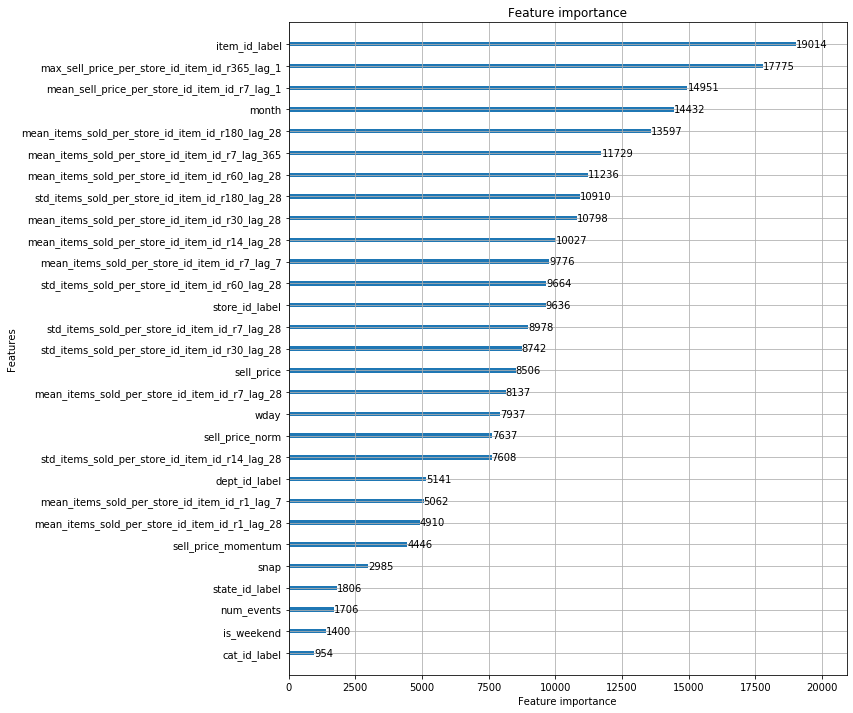

In [61]:
## examine the feature importane
## ideally, one wants a good balance between recursive features (lag/rolling depends on data within 28 days) and solid features

lgb.plot_importance(reg_model, figsize=(10, 12))

### 2. Error analysis
- We recursively "predict" the validation set (last 28 days of the known data) and check with the ground-truth

In [150]:
sales_by_date_copy = sales_by_date.copy()

In [151]:
sales_by_date_copy['items_sold_true'] = sales_by_date_copy['items_sold']

In [153]:
sales_by_date_copy.reset_index(inplace=True)

In [154]:
%%time

## perform recursive prediction

from datetime import datetime
from datetime import timedelta  

## create submission ID

# the magic scaling factor that applies on every score prediction
magic_factors = 1.0

# the threshold below which the prediction is set to zero
zero_threshold = 0.0

# start_date and the number of dates to be predicted
# this error analysis was performed when the validation set was not released. Please use 2016-04-24 to 2016-05-22 after the release
start_date = datetime(2016,3,25)
num_dates = 28

# loop over days and generate score for each day
for i in range(num_dates):
    date = start_date + timedelta(days=i)
    
    # compute the features on-the-fly b/c some features depend on predictions
    X_features = update_features_one_day(sales_by_date_copy, date=date)
    X_pred = X_features[X_features['date'] == date][feature_cols]
    
    # generate predictions
    y_pred = reg_model.predict(X_pred) * magic_factor
    y_pred[y_pred <= zero_threshold] = 0
    
    # update predictions to the sales_by_date dataframe
    sales_by_date_copy.loc[sales_by_date_copy['date'] == date, 'items_sold'] = y_pred

CPU times: user 2min 21s, sys: 10.3 s, total: 2min 31s
Wall time: 57.1 s


In [170]:
## Filter out the final table with our predictions

sales_by_date_copy = sales_by_date_copy.set_index('date').loc['2016-03-25':'2016-04-24'].reset_index()

In [192]:
## randomly sample 10 item_id to visualize

n_item_id = 10

import random
item_id_list = random.sample(list(sales_by_date_copy['item_id'].unique()), n_item_id)

In [196]:
item_id_list

['HOBBIES_1_299',
 'HOUSEHOLD_1_218',
 'HOBBIES_1_183',
 'FOODS_3_043',
 'HOBBIES_1_007',
 'HOBBIES_2_103',
 'HOUSEHOLD_1_122',
 'HOUSEHOLD_2_271',
 'FOODS_2_232',
 'FOODS_3_460']

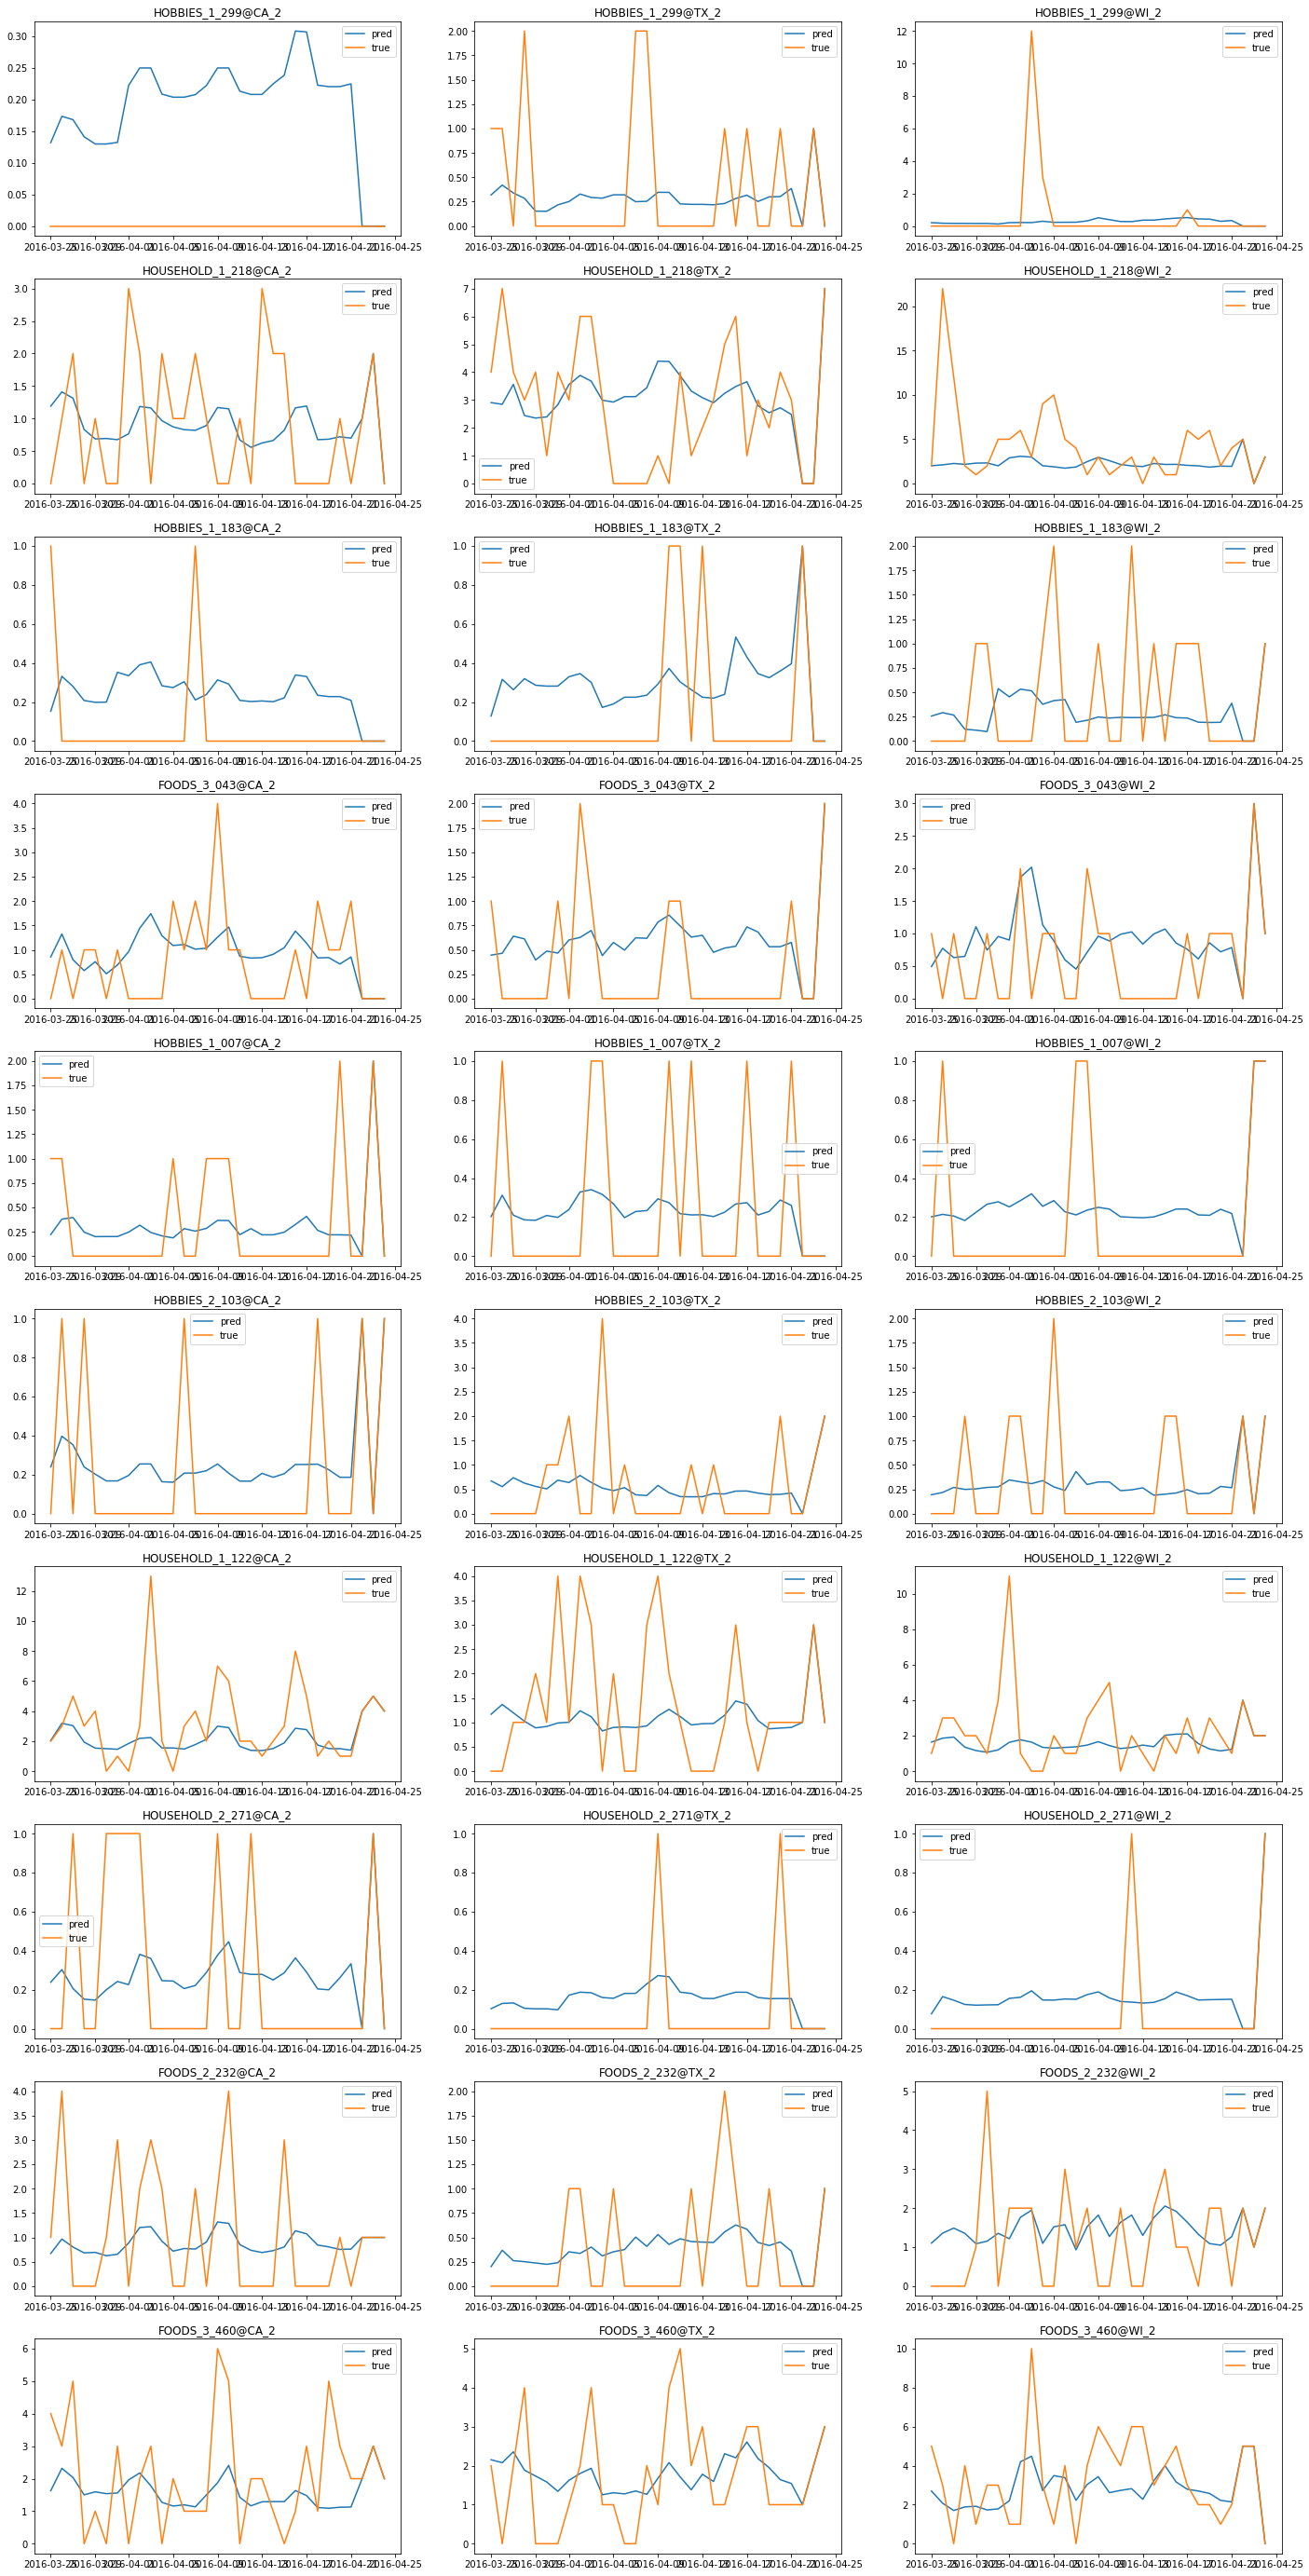

In [198]:
## Check all the above items in three selective stores

fig, axes = plt.subplots(n_item_id, 3, figsize=(24, n_item_id*5))

for i, item_id in enumerate(item_id_list):
    for j, store_id in enumerate(['CA_2', 'TX_2', 'WI_2']):
        df_plot = sales_by_date_copy[(sales_by_date_copy.item_id == item_id) & (sales_by_date_copy.store_id == store_id)]
        axes[i][j].plot(df_plot.date, df_plot.items_sold, label='pred')
        axes[i][j].plot(df_plot.date, df_plot.items_sold_true, label='true')
        axes[i][j].legend()
        axes[i][j].set_title('{}@{}'.format(item_id, store_id))

### Insight on individual items
- Actual sales fluctuate a lot more than predictions. Predictions tend to flatten out.
- This makes sense because actual sales data tend to be noisy
- This is also an indication that one can add more weekday/event type features to improve and make more fluctuating predictions (not implemented here)

In [207]:
## look at the total sales for every store

sales_by_date_copy['total_sales_pred'] = sales_by_date_copy['items_sold']*sales_by_date_copy['sell_price']
sales_by_date_copy['total_sales_true'] = sales_by_date_copy['items_sold_true']*sales_by_date_copy['sell_price']

sales_by_store = sales_by_date_copy.groupby(['store_id', 'date']).agg({'total_sales_pred':['sum'], 'total_sales_true':['sum']})
sales_by_store.columns = ['total_sales_pred', 'total_sales_true']
sales_by_store.reset_index(inplace=True)

In [209]:
store_list = list(sales_by_store['store_id'].unique())

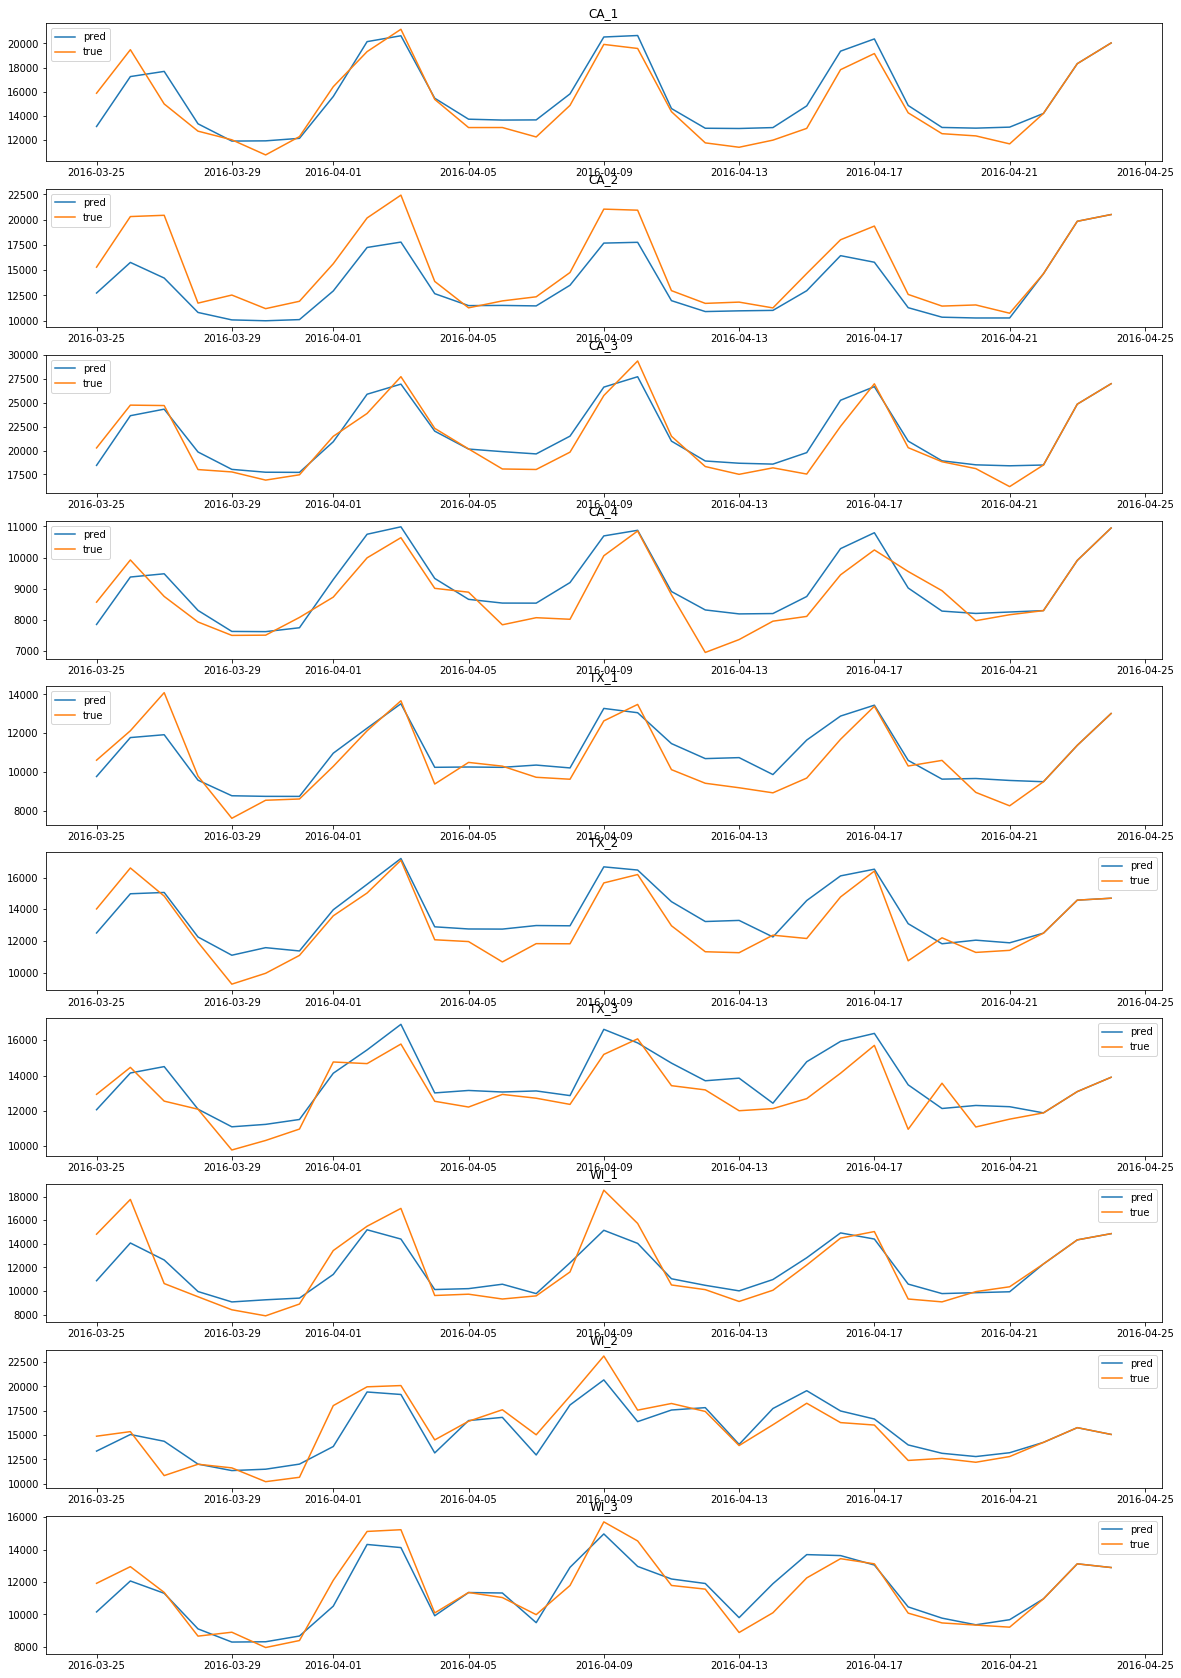

In [213]:
fig, axes = plt.subplots(len(store_list), 1, figsize=(20, len(store_list)*3))

for i, store_id in enumerate(store_list):
    df_plot = sales_by_store[sales_by_store.store_id == store_id]
    axes[i].plot(df_plot.date, df_plot.total_sales_pred, label='pred')
    axes[i].plot(df_plot.date, df_plot.total_sales_true, label='true')
    axes[i].legend()
    axes[i].set_title('{}'.format(store_id))

### Insight on the store-level predictions
- We matched the total sales for each store pretty well!
- This indicates that our prediction are solid despite being quite flat

# Train the final model
- using the optimal parameters
- incorporating the validation set into the training set

In [91]:
import lightgbm as lgb

In [92]:
## Load the data

## Do not dropna because it will screw up the index column (id). We need EVERY ID to make the submission

sales_by_date = pd.read_pickle("../saved_data/df_features_20200625.pkl").reset_index().set_index('date')

In [93]:
sales_by_date.shape

(25825030, 61)

In [94]:
sales_by_date[feature_cols].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25825030 entries, 2014-02-24 to 2016-06-19
Data columns (total 43 columns):
 #   Column                                            Dtype  
---  ------                                            -----  
 0   mean_items_sold_per_store_id_item_id_r1_lag_38    float32
 1   num_events                                        int64  
 2   mean_items_sold_per_store_id_item_id_r1_lag_39    float32
 3   max_sell_price_per_store_id_item_id_r365_lag_1    float32
 4   std_items_sold_per_store_id_item_id_r7_lag_28     float32
 5   store_id_label                                    int64  
 6   mean_items_sold_per_store_id_item_id_r1_lag_31    float32
 7   month                                             int8   
 8   std_items_sold_per_store_id_item_id_r14_lag_28    float32
 9   mean_items_sold_per_store_id_item_id_r1_lag_28    float32
 10  wday                                              int8   
 11  state_id_label                                 

In [98]:
%%time

## define the final training date range
## choose to be 1-year or so because the overall sales are not stationary over the years
## so that we can remove some bias if trained on the most recent year
train_start_date = '2014-04-24'
train_end_date = '2016-05-22'

X_train = sales_by_date[train_start_date : train_end_date][feature_cols].fillna(0)
y_train = sales_by_date[train_start_date : train_end_date][label_col]

CPU times: user 3.6 s, sys: 2.98 s, total: 6.58 s
Wall time: 6.9 s


In [99]:
## check if there is NULL value

X_train.isna().sum()

mean_items_sold_per_store_id_item_id_r1_lag_38      0
num_events                                          0
mean_items_sold_per_store_id_item_id_r1_lag_39      0
max_sell_price_per_store_id_item_id_r365_lag_1      0
std_items_sold_per_store_id_item_id_r7_lag_28       0
store_id_label                                      0
mean_items_sold_per_store_id_item_id_r1_lag_31      0
month                                               0
std_items_sold_per_store_id_item_id_r14_lag_28      0
mean_items_sold_per_store_id_item_id_r1_lag_28      0
wday                                                0
state_id_label                                      0
mean_items_sold_per_store_id_item_id_r60_lag_28     0
sell_price_momentum                                 0
mean_items_sold_per_store_id_item_id_r1_lag_33      0
is_weekend                                          0
mean_items_sold_per_store_id_item_id_r7_lag_365     0
mean_items_sold_per_store_id_item_id_r180_lag_28    0
mean_items_sold_per_store_id

In [250]:
## This is the final parameter table

param_dist = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'num_iterations': 2000,
    'metric': 'rmse',
    'num_leaves': 500,
    'max_depth': 50,
    'learning_rate': 0.03,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 1,
    'lambda_l2': 0.0,
}

reg = lgb.LGBMRegressor(**param_dist)

In [251]:
%%time

## train the model
## one can also try using sell_prices as the sample weight (sample_weight=X_train['sell_price'])
## but seems like no weight gives better result on the public LB

reg.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=100)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's rmse: 2.07403
[200]	training's rmse: 2.00753
[300]	training's rmse: 1.96832
[400]	training's rmse: 1.93502
[500]	training's rmse: 1.90619
[600]	training's rmse: 1.88155
[700]	training's rmse: 1.86062
[800]	training's rmse: 1.84279
[900]	training's rmse: 1.82636
[1000]	training's rmse: 1.81152
[1100]	training's rmse: 1.79886
[1200]	training's rmse: 1.7861
[1300]	training's rmse: 1.77387
[1400]	training's rmse: 1.76179
[1500]	training's rmse: 1.75214
[1600]	training's rmse: 1.74103
[1700]	training's rmse: 1.73204
[1800]	training's rmse: 1.72266
[1900]	training's rmse: 1.71433
[2000]	training's rmse: 1.70594
CPU times: user 7h 30min 39s, sys: 3min 13s, total: 7h 33min 52s
Wall time: 30min 5s


LGBMRegressor(bagging_fraction=0.5, bagging_freq=1, boosting_type='gbdt',
              class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
              importance_type='split', lambda_l2=0.0, learning_rate=0.03,
              max_depth=50, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=2000, num_leaves=500,
              objective='tweedie', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0,
              tweedie_variance_power=1.1)

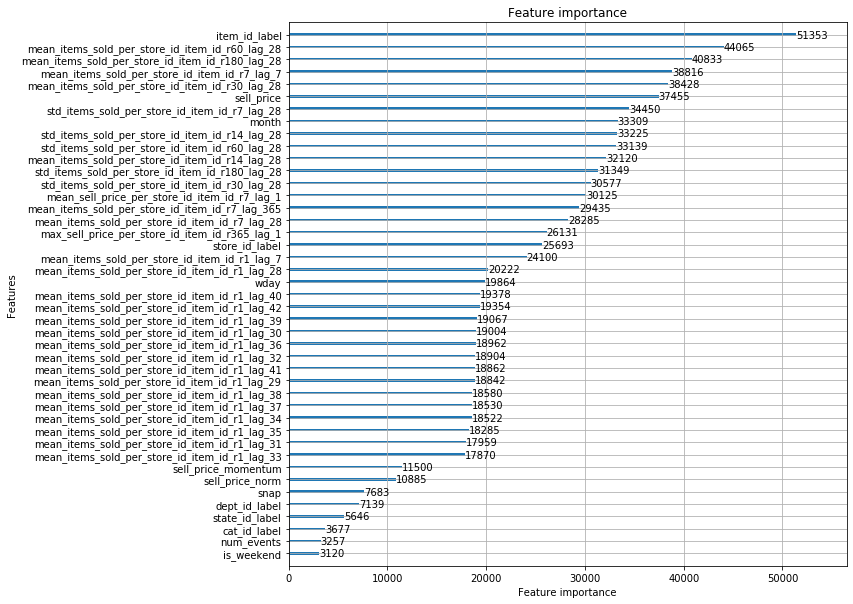

In [252]:
lgb.plot_importance(reg, figsize=(10, 10))

In [253]:
# save model

reg.booster_.save_model('../saved_models/lgbm_model_20200628_2000_noweight.mdl')

# Generate submission

### 1. Load data and model

In [202]:
import gc

In [269]:
## load the saved model

reg_model = lgb.Booster(model_file='../saved_models/lgbm_model_20200628_2000_noweight.mdl')

In [270]:
## load the data

sales_by_date = pd.read_pickle("../saved_data/df_features_20200625.pkl").reset_index().set_index('date')

In [271]:
unused_cols = ['id','item_id','dept_id','cat_id','store_id','state_id','items_sold','weekday','year','event_name_1','event_type_1',
              'event_name_2','event_type_2','snap_CA','snap_TX','snap_WI','event_1_isna','event_2_isna']

feature_cols = list(set(sales_by_date.columns) - set(unused_cols))

In [272]:
feature_cols

['mean_items_sold_per_store_id_item_id_r1_lag_38',
 'num_events',
 'mean_items_sold_per_store_id_item_id_r1_lag_39',
 'max_sell_price_per_store_id_item_id_r365_lag_1',
 'std_items_sold_per_store_id_item_id_r7_lag_28',
 'store_id_label',
 'mean_items_sold_per_store_id_item_id_r1_lag_31',
 'month',
 'std_items_sold_per_store_id_item_id_r14_lag_28',
 'mean_items_sold_per_store_id_item_id_r1_lag_28',
 'wday',
 'state_id_label',
 'mean_items_sold_per_store_id_item_id_r60_lag_28',
 'sell_price_momentum',
 'mean_items_sold_per_store_id_item_id_r1_lag_33',
 'is_weekend',
 'mean_items_sold_per_store_id_item_id_r7_lag_365',
 'mean_items_sold_per_store_id_item_id_r180_lag_28',
 'mean_items_sold_per_store_id_item_id_r1_lag_36',
 'sell_price',
 'mean_items_sold_per_store_id_item_id_r1_lag_41',
 'item_id_label',
 'std_items_sold_per_store_id_item_id_r30_lag_28',
 'mean_items_sold_per_store_id_item_id_r1_lag_40',
 'mean_items_sold_per_store_id_item_id_r1_lag_30',
 'sell_price_norm',
 'std_items_sold_

In [273]:
sales_by_date.reset_index(inplace=True)

In [274]:
sales_by_date.head(2)

,date,id,item_id,dept_id,cat_id,store_id,state_id,items_sold,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,event_1_isna,event_2_isna,num_events,snap,is_weekend,mean_items_sold_per_store_id_item_id_r1_lag_7,mean_items_sold_per_store_id_item_id_r1_lag_28,mean_items_sold_per_store_id_item_id_r1_lag_29,mean_items_sold_per_store_id_item_id_r1_lag_30,mean_items_sold_per_store_id_item_id_r1_lag_31,mean_items_sold_per_store_id_item_id_r1_lag_32,mean_items_sold_per_store_id_item_id_r1_lag_33,mean_items_sold_per_store_id_item_id_r1_lag_34,mean_items_sold_per_store_id_item_id_r1_lag_35,mean_items_sold_per_store_id_item_id_r1_lag_36,mean_items_sold_per_store_id_item_id_r1_lag_37,mean_items_sold_per_store_id_item_id_r1_lag_38,mean_items_sold_per_store_id_item_id_r1_lag_39,mean_items_sold_per_store_id_item_id_r1_lag_40,mean_items_sold_per_store_id_item_id_r1_lag_41,mean_items_sold_per_store_id_item_id_r1_lag_42,mean_items_sold_per_store_id_item_id_r7_lag_7,mean_items_sold_per_store_id_item_id_r7_lag_365,mean_items_sold_per_store_id_item_id_r7_lag_28,mean_items_sold_per_store_id_item_id_r14_lag_28,mean_items_sold_per_store_id_item_id_r30_lag_28,mean_items_sold_per_store_id_item_id_r60_lag_28,mean_items_sold_per_store_id_item_id_r180_lag_28,std_items_sold_per_store_id_item_id_r7_lag_28,std_items_sold_per_store_id_item_id_r14_lag_28,std_items_sold_per_store_id_item_id_r30_lag_28,std_items_sold_per_store_id_item_id_r60_lag_28,std_items_sold_per_store_id_item_id_r180_lag_28,max_sell_price_per_store_id_item_id_r365_lag_1,mean_sell_price_per_store_id_item_id_r7_lag_1,sell_price_norm,sell_price_momentum,item_id_label,dept_id_label,cat_id_label,store_id_label,state_id_label
0,2014-02-24,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,Monday,3,2,2014,no_event,NaN,no_event,NaN,0,0,0,8.26,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1437,3,1,0,0
1,2014-02-24,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,Monday,3,2,2014,no_event,NaN,no_event,NaN,0,0,0,3.97,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1438,3,1,0,0


### 2. Submission part 1 - the validation set
- This is the data used for validation
- The true values have already been posted in the SALES_TRAIN_EVALUATION.CSV
- We will read that file and fill the numbers in there

In [281]:
%%time

sales = pd.read_csv('../input_data/sales_train_evaluation.csv').pipe(reduce_mem_usage, verbose=True)

Mem. usage decreased to 95.61 Mb (78.9% reduction)
CPU times: user 1min 38s, sys: 33.7 s, total: 2min 12s
Wall time: 2min 12s


In [282]:
## take the ID column and the d_1914 to d_1941 columns
## rename d_1914 - d_1941 to be F1 - F28

cols_old = ['id'] + ['d_'+str(x) for x in list(range(1914, 1942))]
cols_new = ['id'] + ['F'+str(x) for x in list(range(1, 29))]

submission = sales[cols_old].copy()
submission.columns = cols_new

In [283]:
del sales; gc.collect()

22

In [284]:
submission["id"] = submission["id"].str.replace("evaluation$", "validation")

In [285]:
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_validation,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_validation,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_validation,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


- Uncomment the following if one wants to evaluate the public LB (we will "predict" the evaluation set as opposed to use the true values)

In [280]:
# for i in range(28):
#     submission['F%d' % (i+1)] = 0

In [266]:
# %%time

# ## generate submission scores

# from datetime import datetime
# from datetime import timedelta  

# ## create submission ID

# # the magic scaling factor that applies on every score prediction
# magic_factors = [1.0]

# # the threshold below which the prediction is set to zero
# zero_threshold = 0.0

# # start_date and the number of dates to be predicted
# start_date = datetime(2016,4,25)
# num_dates = 28

# # loop over days and generate score for each day
# for magic_factor in magic_factors:
#     print(magic_factor)
    
#     for i in range(num_dates):
        
#         date = start_date + timedelta(days=i)
    
#         # compute the features on-the-fly b/c some features depend on predictions
#         X_features = update_features_one_day(sales_by_date, date=date)
#         X_pred = X_features[X_features['date'] == date][feature_cols]
    
#         # generate predictions
#         y_pred = reg_model.predict(X_pred) * magic_factor
#         y_pred[y_pred <= zero_threshold] = 0
    
#         # append predictions to the submission dataframe
#         submission['F%d' % (i+1)] += y_pred
    
#         # update predictions to the sales_by_date dataframe
#         sales_by_date.loc[sales_by_date['date'] == date, 'items_sold'] = y_pred
        
# submission = submission.set_index('id').apply(lambda x:x/len(magic_factors)).reset_index()

1.0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
CPU times: user 9min 18s, sys: 39.9 s, total: 9min 58s
Wall time: 3min 18s


In [267]:
# submission2 = submission.copy()
# submission2["id"] = submission2["id"].str.replace("validation$", "evaluation")

# submission_all = pd.concat([submission, submission2], axis=0, sort=False)
# submission_all.to_csv("../submission_files/submission_20200628_noweight.csv",index=False)

### 3. Submission part 2 - the evaluation set

In [286]:
submission2 = submission.copy()

In [287]:
## rename the index from "validation" to "evaluation"

submission2["id"] = submission2["id"].str.replace("validation$", "evaluation")

In [288]:
for i in range(28):
    submission2['F%d' % (i+1)] = 0

In [289]:
submission2.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [290]:
%%time

## generate submission scores

from datetime import datetime
from datetime import timedelta  

## create submission ID

# the magic scaling factor that applies on every score prediction
magic_factors = [1.0]

# the threshold below which the prediction is set to zero
zero_threshold = 0.0

# start_date and the number of dates to be predicted
start_date = datetime(2016,5,23)
num_dates = 28

# loop over days and generate score for each day
for magic_factor in magic_factors:
    print(magic_factor)
    
    for i in range(num_dates):
        date = start_date + timedelta(days=i)
    
        # compute the features on-the-fly b/c some features depend on predictions
        X_features = update_features_one_day(sales_by_date, date=date)
        X_pred = X_features[X_features['date'] == date][feature_cols]
    
        # generate predictions
        y_pred = reg_model.predict(X_pred) * magic_factor
        y_pred[y_pred <= zero_threshold] = 0
    
        # append predictions to the submission dataframe
        submission2['F%d' % (i+1)] += y_pred
    
        # update predictions to the sales_by_date dataframe
        sales_by_date.loc[sales_by_date['date'] == date, 'items_sold'] = y_pred
        
submission2 = submission2.set_index('id').apply(lambda x:x/len(magic_factors)).reset_index()

1.0
CPU times: user 9min 34s, sys: 40.5 s, total: 10min 14s
Wall time: 3min 17s


In [291]:
submission2.head(2)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.862394,0.717146,0.668363,0.854802,0.973417,1.104841,1.293345,1.022276,0.841913,0.937386,0.888397,0.921588,1.250512,1.251186,0.990158,0.876284,0.896338,0.882605,1.068116,1.353842,1.256059,0.931354,0.842541,0.801418,0.869647,1.064699,1.246851,1.060254
1,HOBBIES_1_002_CA_1_evaluation,0.323626,0.349655,0.301829,0.289511,0.333741,0.378324,0.326018,0.256976,0.231549,0.240050,0.239019,0.280209,0.322048,0.321921,0.252064,0.227120,0.227903,0.226886,0.264106,0.324683,0.376473,0.307168,0.315059,0.299367,0.279447,0.316260,0.388619,0.353032


In [292]:
submission2.tail(2)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
30488,FOODS_3_826_WI_3_evaluation,1.095194,1.369665,1.049645,1.190830,1.450440,1.535087,1.334652,1.118972,0.918363,0.935500,1.232987,1.346469,1.293314,1.554495,1.292889,0.982222,1.247614,1.240803,1.126482,1.475703,1.510064,1.107525,1.438744,1.338774,1.125829,1.288080,1.362952,1.213347
30489,FOODS_3_827_WI_3_evaluation,1.669351,1.438462,1.120793,1.533751,1.800821,1.920907,1.784780,1.363731,1.237132,1.327058,1.623087,1.920332,1.709554,1.988970,1.762258,1.252942,1.445719,1.356182,1.392536,1.762812,1.674399,1.356176,1.686514,1.593237,1.362936,1.565908,1.862888,1.617873


### 4. Concat the two parts to be the final submission file

In [293]:
submission_all = pd.concat([submission, submission2], axis=0, sort=False)
submission_all.to_csv("../submission_files/submission_20200628.csv",index=False)

In [294]:
submission_all.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0,0.0,0.0,2.0,0.0,3.0,5.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,2.0,2.0,1.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,1.0
1,HOBBIES_1_002_CA_1_validation,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0,0.0,1.0
3,HOBBIES_1_004_CA_1_validation,0.0,0.0,1.0,2.0,4.0,1.0,6.0,4.0,0.0,0.0,0.0,2.0,2.0,4.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,4.0,0.0,1.0,3.0,0.0,2.0,6.0
4,HOBBIES_1_005_CA_1_validation,1.0,0.0,2.0,3.0,1.0,0.0,3.0,2.0,3.0,1.0,1.0,3.0,2.0,3.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,0.0


In [295]:
submission_all.tail()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
30485,FOODS_3_823_WI_3_evaluation,0.453675,0.471683,0.458656,0.461383,0.562425,0.671176,0.589898,0.496442,0.505242,0.471398,0.615965,0.658183,0.617894,0.783630,0.633866,0.477271,0.615790,0.594249,0.579261,0.717239,0.783587,0.519545,0.665226,0.661438,0.518156,0.569778,0.654259,0.624982
30486,FOODS_3_824_WI_3_evaluation,0.140043,0.147730,0.164678,0.261782,0.262548,0.338984,0.310885,0.271970,0.279878,0.227434,0.357132,0.368529,0.299875,0.387741,0.330207,0.247583,0.270893,0.247358,0.222388,0.300297,0.301062,0.203595,0.250734,0.243041,0.220820,0.239254,0.283846,0.258501
30487,FOODS_3_825_WI_3_evaluation,0.880043,0.655340,0.668821,0.630979,0.769543,0.871489,0.975967,0.764628,0.676761,0.615542,0.877545,0.906910,0.809776,1.014872,0.838912,0.646816,0.876992,0.874294,0.749360,1.095744,1.093109,0.738271,0.890554,0.911972,0.679108,0.793661,0.795516,0.816571
30488,FOODS_3_826_WI_3_evaluation,1.095194,1.369665,1.049645,1.190830,1.450440,1.535087,1.334652,1.118972,0.918363,0.935500,1.232987,1.346469,1.293314,1.554495,1.292889,0.982222,1.247614,1.240803,1.126482,1.475703,1.510064,1.107525,1.438744,1.338774,1.125829,1.288080,1.362952,1.213347
30489,FOODS_3_827_WI_3_evaluation,1.669351,1.438462,1.120793,1.533751,1.800821,1.920907,1.784780,1.363731,1.237132,1.327058,1.623087,1.920332,1.709554,1.988970,1.762258,1.252942,1.445719,1.356182,1.392536,1.762812,1.674399,1.356176,1.686514,1.593237,1.362936,1.565908,1.862888,1.617873


### 5. Sanity check of the submission files

In [240]:
sales_by_date_copy = sales_by_date[sales_by_date.date >= '2016-01-01']

In [241]:
sales_by_date_copy.head(2)

,date,id,item_id,dept_id,cat_id,store_id,state_id,items_sold,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,event_1_isna,event_2_isna,num_events,snap,is_weekend,mean_items_sold_per_store_id_item_id_r1_lag_7,mean_items_sold_per_store_id_item_id_r1_lag_28,mean_items_sold_per_store_id_item_id_r1_lag_29,mean_items_sold_per_store_id_item_id_r1_lag_30,mean_items_sold_per_store_id_item_id_r1_lag_31,mean_items_sold_per_store_id_item_id_r1_lag_32,mean_items_sold_per_store_id_item_id_r1_lag_33,mean_items_sold_per_store_id_item_id_r1_lag_34,mean_items_sold_per_store_id_item_id_r1_lag_35,mean_items_sold_per_store_id_item_id_r1_lag_36,mean_items_sold_per_store_id_item_id_r1_lag_37,mean_items_sold_per_store_id_item_id_r1_lag_38,mean_items_sold_per_store_id_item_id_r1_lag_39,mean_items_sold_per_store_id_item_id_r1_lag_40,mean_items_sold_per_store_id_item_id_r1_lag_41,mean_items_sold_per_store_id_item_id_r1_lag_42,mean_items_sold_per_store_id_item_id_r7_lag_7,mean_items_sold_per_store_id_item_id_r7_lag_365,mean_items_sold_per_store_id_item_id_r7_lag_28,mean_items_sold_per_store_id_item_id_r14_lag_28,mean_items_sold_per_store_id_item_id_r30_lag_28,mean_items_sold_per_store_id_item_id_r60_lag_28,mean_items_sold_per_store_id_item_id_r180_lag_28,std_items_sold_per_store_id_item_id_r7_lag_28,std_items_sold_per_store_id_item_id_r14_lag_28,std_items_sold_per_store_id_item_id_r30_lag_28,std_items_sold_per_store_id_item_id_r60_lag_28,std_items_sold_per_store_id_item_id_r180_lag_28,max_sell_price_per_store_id_item_id_r365_lag_1,mean_sell_price_per_store_id_item_id_r7_lag_1,sell_price_norm,sell_price_momentum,item_id_label,dept_id_label,cat_id_label,store_id_label,state_id_label
20611240,2016-01-01,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0.0,Friday,7,1,2016,NewYear,National,no_event,NaN,1,1,0,8.26,1,0,1,1,0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.285714,0.857143,0.571429,0.533333,0.533333,0.627778,0.899735,0.755929,0.730297,0.769474,0.818983,8.26,8.26,1.0,1.0,1437,3,1,0,0
20611241,2016-01-01,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0.0,Friday,7,1,2016,NewYear,National,no_event,NaN,1,1,0,3.97,1,0,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.142857,0.142857,0.285714,0.366667,0.350000,0.383333,0.377964,0.825420,0.668675,0.684576,0.687275,3.97,3.97,1.0,1.0,1438,3,1,0,0


In [245]:
## randomly sample 10 id to evaluate

n_id = 10

import random
id_list = random.sample(list(sales_by_date_copy['id'].unique()), n_id)

In [246]:
id_list

['HOUSEHOLD_2_105_CA_4_evaluation',
 'FOODS_3_547_WI_2_evaluation',
 'FOODS_3_564_CA_4_evaluation',
 'HOBBIES_1_399_CA_3_evaluation',
 'HOUSEHOLD_2_080_CA_2_evaluation',
 'HOBBIES_1_240_TX_1_evaluation',
 'HOUSEHOLD_2_364_WI_1_evaluation',
 'FOODS_3_646_TX_1_evaluation',
 'FOODS_3_673_CA_1_evaluation',
 'HOUSEHOLD_1_535_CA_2_evaluation']

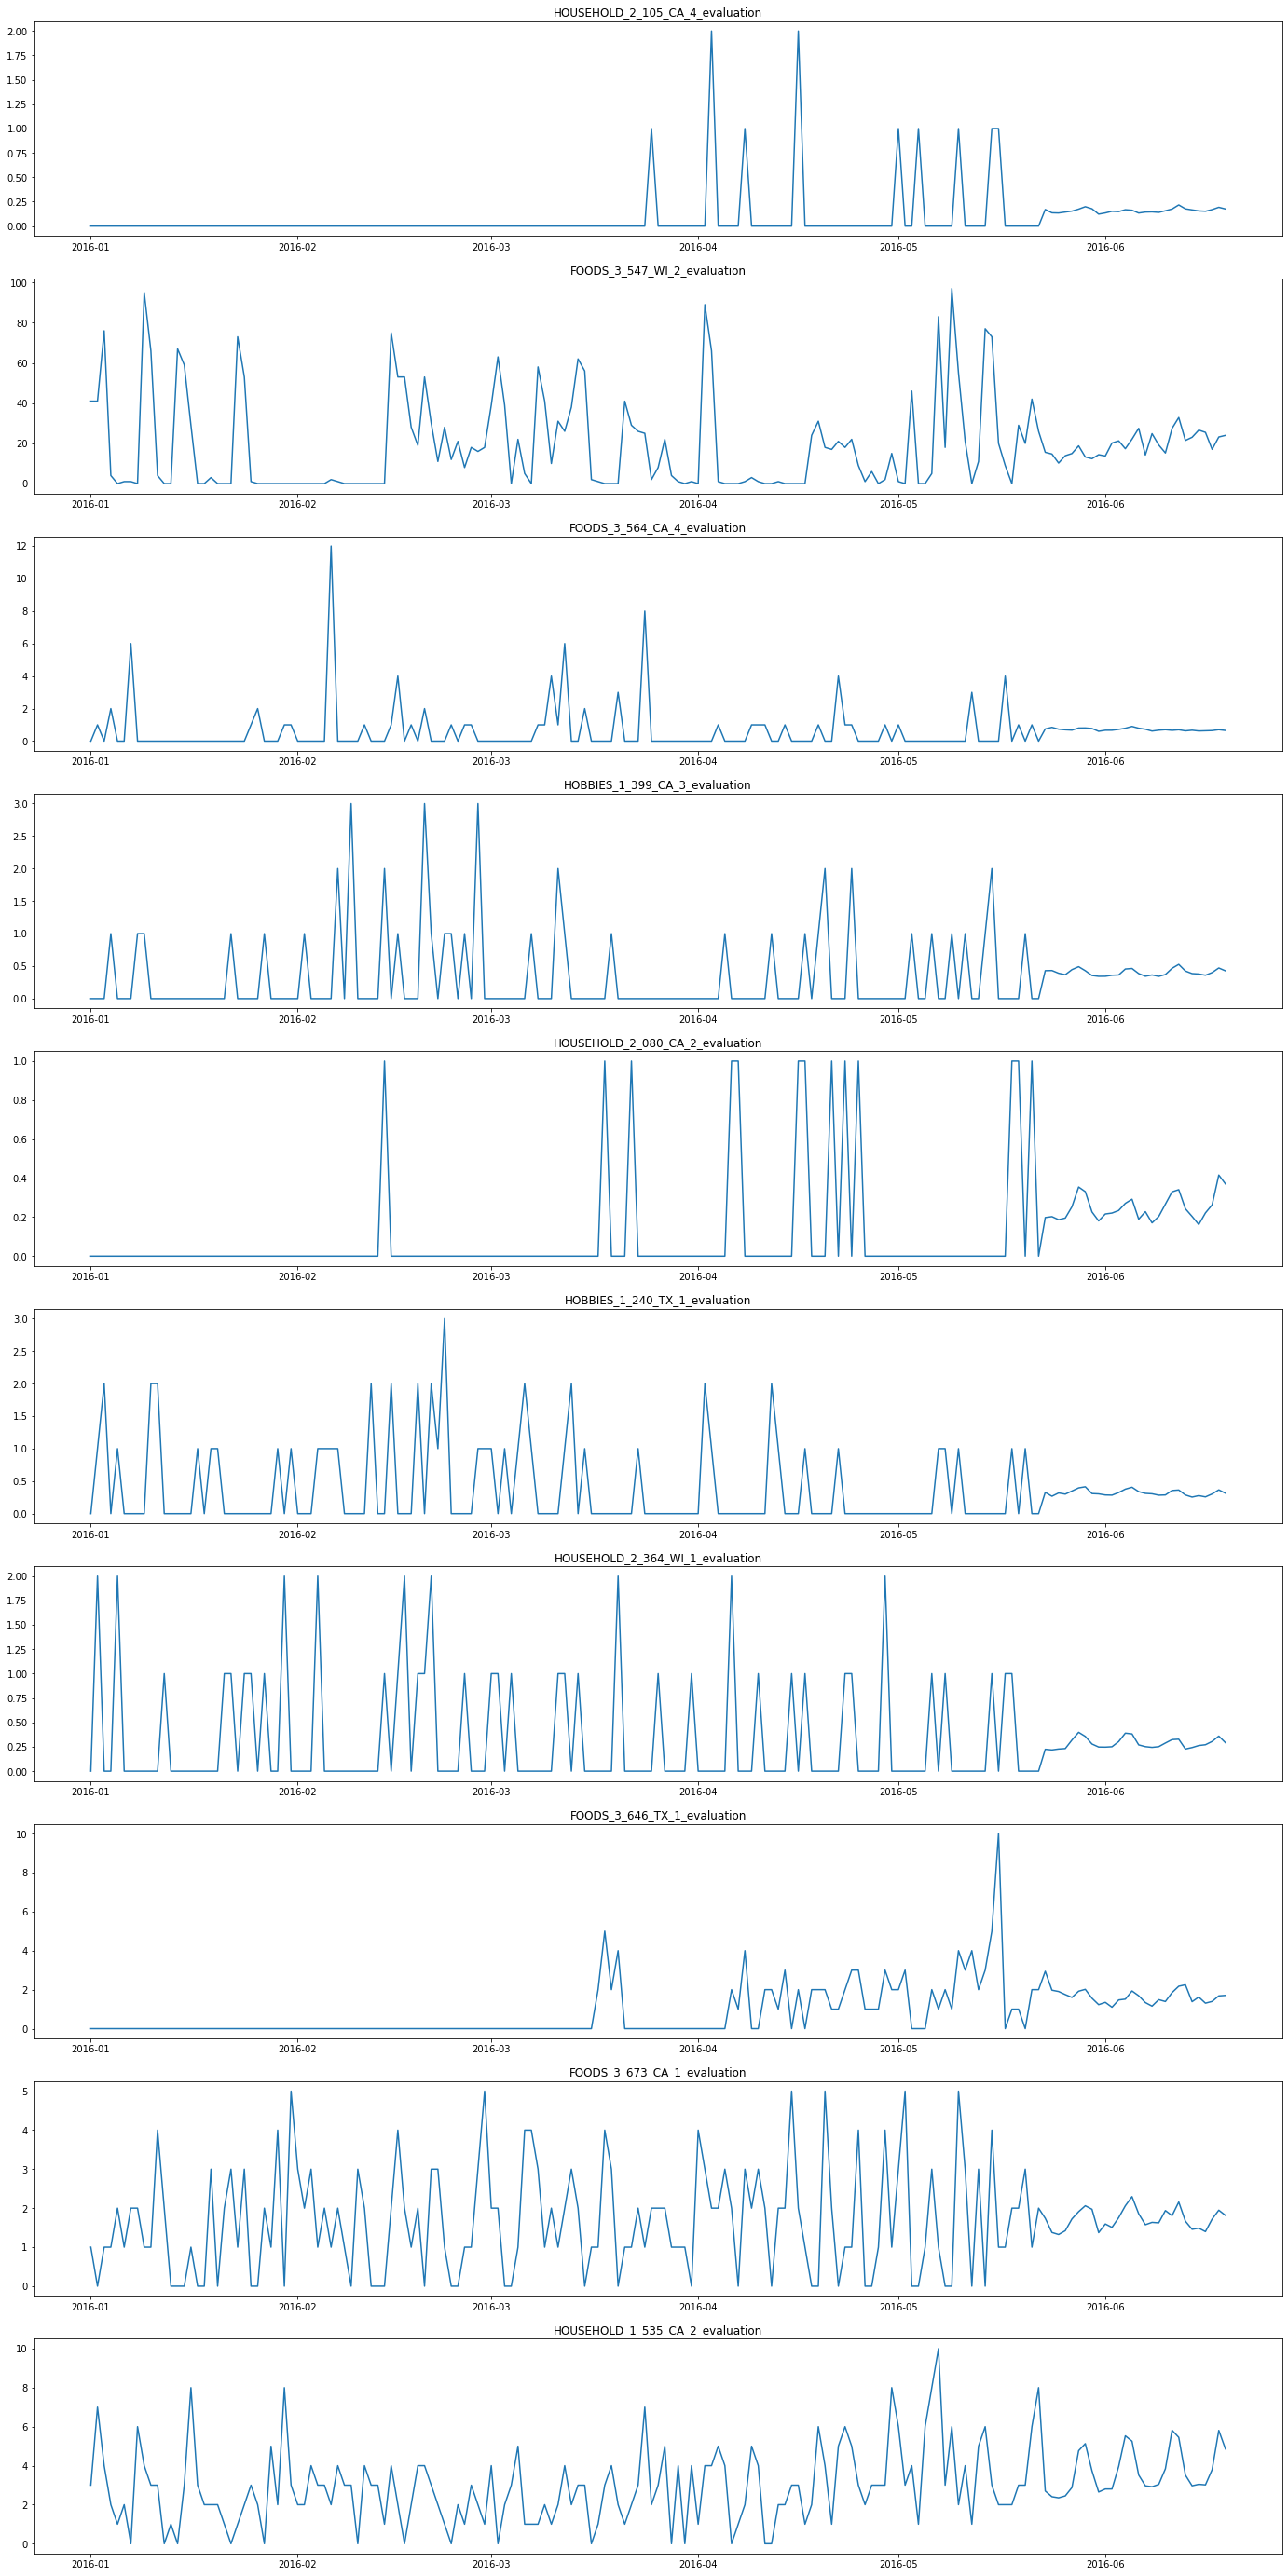

In [249]:
## the last 28 days plotted are the PREDICTIONS

fig, axes = plt.subplots(n_id, 1, figsize=(24, n_item_id*5))

for i, id in enumerate(id_list):
    df_plot = sales_by_date_copy[sales_by_date_copy.id == id]
    axes[i].plot(df_plot.date, df_plot.items_sold)
    axes[i].set_title('{}'.format(id))

### Insight
- The trend of the prediction looks good. We are using this for final submission!!

# Public LB evaluation
- This is to evaluate the Public LeaderBoard
- I ran this to get an idea of the public score, in prediction mode for the validation set (we are not predicting the validation set in the final submission)

In [118]:
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm

In [119]:
## evaluation metric
## from https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834 and edited to get scores at all levels
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        group_ids = []
        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            group_ids.append(group_id)
            all_scores.append(lv_scores.sum())

        return group_ids, all_scores

In [121]:
%%time

## reading data
df_train_full = pd.read_csv("../input_data/sales_train_evaluation.csv")
df_calendar = pd.read_csv("../input_data/calendar.csv")
df_prices = pd.read_csv("../input_data/sell_prices.csv")

df_sample_submission = pd.read_csv("../input_data/sample_submission.csv")
df_sample_submission["order"] = range(df_sample_submission.shape[0])

df_train = df_train_full.iloc[:, :-28]
df_valid = df_train_full.iloc[:, -28:]

evaluator = WRMSSEEvaluator(df_train, df_valid, df_calendar, df_prices)


CPU times: user 26.4 s, sys: 3.03 s, total: 29.4 s
Wall time: 29.5 s


In [122]:
df_valid.head()

,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [268]:
## note that this is a submission file that we PREDICT the validation set
## not the final submission (which we use the ground-truth for the validation set)
## but the model is the same
submission_file_name = 'submission_20200628_val.csv'

preds_valid = pd.read_csv("../submission_files/{}".format(submission_file_name))
preds_valid = preds_valid[preds_valid.id.str.contains("validation")]
preds_valid = preds_valid.merge(df_sample_submission[["id", "order"]], on = "id").sort_values("order").drop(["id", "order"], axis = 1)
preds_valid.rename(columns = {
    "F1": "d_1914", "F2": "d_1915", "F3": "d_1916", "F4": "d_1917", "F5": "d_1918", "F6": "d_1919", "F7": "d_1920",
    "F8": "d_1921", "F9": "d_1922", "F10": "d_1923", "F11": "d_1924", "F12": "d_1925", "F13": "d_1926", "F14": "d_1927",
    "F15": "d_1928", "F16": "d_1929", "F17": "d_1930", "F18": "d_1931", "F19": "d_1932", "F20": "d_1933", "F21": "d_1934",
    "F22": "d_1935", "F23": "d_1936", "F24": "d_1937", "F25": "d_1938", "F26": "d_1939", "F27": "d_1940", "F28": "d_1941"
}, inplace = True)

groups, scores = evaluator.score(preds_valid)

score_public_lb = np.mean(scores)

for i in range(len(groups)):
    print(f"Score for group {groups[i]}: {round(scores[i], 5)}")

print(f"\nPublic LB Score: {round(score_public_lb, 5)}")

Score for group all_id: 0.30456
Score for group state_id: 0.34826
Score for group store_id: 0.42464
Score for group cat_id: 0.34947
Score for group dept_id: 0.39453
Score for group ['state_id', 'cat_id']: 0.40049
Score for group ['state_id', 'dept_id']: 0.45117
Score for group ['store_id', 'cat_id']: 0.48253
Score for group ['store_id', 'dept_id']: 0.54635
Score for group item_id: 0.77837
Score for group ['item_id', 'state_id']: 0.7917
Score for group ['item_id', 'store_id']: 0.799

Public LB Score: 0.50592
